# Exploratory Data Analysis

In [4]:
# load library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import zipfile
import urllib.request
import io

In [28]:
# load raw and processed data
url = "https://github.com/zxyao5148/STAT3612_2023_1A_GroupProject/raw/main/raw_data/ehr_preprocessed_seq_by_day_cat_embedding.pkl.zip"
with urllib.request.urlopen(url) as response:
    with zipfile.ZipFile(io.BytesIO(response.read())) as zip_file:
        with zip_file.open("ehr_preprocessed_seq_by_day_cat_embedding.pkl", "r") as file:
            EHR = pd.read_pickle(file)
train = pd.read_csv("https://github.com/zxyao5148/STAT3612_2023_1A_GroupProject/raw/main/raw_data/train.csv")
valid = pd.read_csv("https://github.com/zxyao5148/STAT3612_2023_1A_GroupProject/raw/main/raw_data/valid.csv")
test = pd.read_csv("https://github.com/zxyao5148/STAT3612_2023_1A_GroupProject/raw/main/raw_data/test.csv")
print(train.shape)
print(test.shape)
print(valid.shape)
print(len(EHR['feature_cols']))

(55941, 13)
(17933, 12)
(13598, 13)
171


In [29]:
# extract last-day observations
train['StudyDate'] = pd.to_datetime(train['StudyDate'], format='%Y%m%d')
train_latest_date_idxs = train.groupby('id')['StudyDate'].idxmax()
train_masked = train.loc[train_latest_date_idxs]


valid['StudyDate'] = pd.to_datetime(valid['StudyDate'], format='%Y%m%d')
valid_latest_date_idxs = valid.groupby('id')['StudyDate'].idxmax()
valid_masked = valid.loc[valid_latest_date_idxs]

test['StudyDate'] = pd.to_datetime(test['StudyDate'], format='%Y%m%d')
test_latest_date_idxs = test.groupby('id')['StudyDate'].idxmax()
test_masked = test.loc[test_latest_date_idxs]

print(train_masked.shape)
print(valid_masked.shape)
print(test_masked.shape)

(9271, 13)
(2325, 13)
(2936, 12)


In [30]:
# merge train and valid
train = pd.concat([train, valid])
train_masked = pd.concat([train_masked, valid_masked])
print(train.shape)
print(train_masked.shape)

(69539, 13)
(11596, 13)


In [61]:
# construct merged dataframe (admit info + feature value)
train_merged_admits_latest = []
train_merged_admits_median = []
for _, admit in train_masked.iterrows():
    feat_arr_latest = pd.Series(EHR['feat_dict'][admit['id']][-1], index=EHR['feature_cols'])
    feat_arr_median = round(pd.Series(np.nanmedian(EHR['feat_dict'][admit['id']], axis=0), index=EHR['feature_cols']))
    train_merged_admits_latest.append(pd.concat([admit, feat_arr_latest]))
    train_merged_admits_median.append(pd.concat([admit, feat_arr_median]))
train_merged_df_latest = pd.DataFrame(train_merged_admits_latest)
train_merged_df_median = pd.DataFrame(train_merged_admits_median)

test_merged_admits_latest = []
test_merged_admits_median = []
for _, admit in test_masked.iterrows():
    feat_arr_latest = pd.Series(EHR['feat_dict'][admit['id']][-1], index=EHR['feature_cols'])
    feat_arr_median = round(pd.Series(np.nanmedian(EHR['feat_dict'][admit['id']], axis=0), index=EHR['feature_cols']))
    test_merged_admits_latest.append(pd.concat([admit, feat_arr_latest]))
    test_merged_admits_median.append(pd.concat([admit, feat_arr_median]))
test_merged_df_latest = pd.DataFrame(test_merged_admits_latest)
test_merged_df_median = pd.DataFrame(test_merged_admits_median)

print(train_merged_df_latest.shape) 
train_merged_df_latest.head(5)

(11596, 184)


id  subject_id   hadm_id            admittime  \
0  10001884_26184834    10001884  26184834  2131-01-07 20:39:00   
1  10003019_20962108    10003019  20962108  2176-01-06 15:52:00   
2  10003400_20214994    10003400  20214994  2137-02-24 10:00:00   
3  10003400_23559586    10003400  23559586  2137-08-04 00:07:00   
4  10004235_24181354    10004235  24181354  2196-02-24 14:38:00   

             dischtime            deathtime  \
0  2131-01-20 05:15:00  2131-01-20 05:15:00   
1  2176-01-14 18:09:00                  NaN   
2  2137-03-19 15:45:00                  NaN   
3  2137-09-02 17:05:00  2137-09-02 17:05:00   
4  2196-03-04 14:02:00                  NaN   

                                       dicom_id  study_id ViewPosition  \
0  469d0d94-3dad5068-efac76ef-a28cc502-68fe6275  50376803           AP   
1  c584b5c4-b5b1dad6-a6f30167-c0411948-46379f73  53098685           AP   
2  01275cbe-a2f95d71-0374e495-68b16452-ebdcb789  51345654           AP   
3  fc09630f-022d31c2-408b148f-95c499df-e8a6b18e  50805197           AP   
4  f9c51c13-4a226906-c3daea10-5b1e4027-ae2ed354  57921415           AP   

   StudyDate  ...  PRE-NATAL VITAMINS ANESTHETICS  ANTIBIOTICS  \
0 2131-01-15  ...                   0           0            4   
1 2176-01-13  ...                   0           1            3   
2 2137-03-09  ...                   0           0            9   
3 2137-08-27  ...                   0           2            7   
4 2196-02-29  ...                   0           2           12   

   ANTIHYPERGLYCEMICS  ANTIINFLAM.TUMOR NECROSIS FACTOR INHIBITING AGENTS  \
0                   0                                                  0    
1                   0                                                  0    
2                   0                                                  0    
3                   0                                                  0    
4                   3                                                  0    

   SEDATIVE/HYPNOTICS  ANTIDOTES  AUTONOMIC DRUGS  VITAMINS  BIOLOGICALS  
0                   2          0                1         0            0  
1                   0          0                0         0            0  
2                   1          0                0         1            0  
3                   1          0                0         1            0  
4                   0          0                3         0            0  

[5 rows x 184 columns]

In [32]:
# summary statistics
train_merged_df_latest.describe()
#train_merged_df_median.describe()

subject_id       hadm_id      study_id      StudyTime  \
count  1.159600e+04  1.159600e+04  1.159600e+04   11596.000000   
mean   1.499595e+07  2.500018e+07  5.475194e+07  106668.187234   
std    2.869858e+06  2.903838e+06  2.883741e+06   51293.847631   
min    1.000188e+07  2.000130e+07  5.000012e+07      11.296000   
25%    1.253298e+07  2.249399e+07  5.223508e+07   73409.941000   
50%    1.499722e+07  2.502440e+07  5.466658e+07  102509.390500   
75%    1.747891e+07  2.752521e+07  5.721184e+07  142768.804500   
max    1.999884e+07  2.999960e+07  5.999943e+07  235940.984000   

       readmitted_within_30days           age        gender     ethnicity  \
count              11596.000000  11596.000000  11596.000000  11596.000000   
mean                   0.175233     66.233098      0.546482      5.062263   
std                    0.380183     16.251922      0.497856      1.606612   
min                    0.000000     18.000000      0.000000      0.000000   
25%                    0.000000     57.000000      0.000000      5.000000   
50%                    0.000000     68.000000      1.000000      6.000000   
75%                    0.000000     78.000000      1.000000      6.000000   
max                    1.000000     98.000000      1.000000      6.000000   

            Y90-Y99       G30-G32  ...  PRE-NATAL VITAMINS   ANESTHETICS  \
count  11596.000000  11596.000000  ...        11596.000000  11596.000000   
mean       0.001466      0.000259  ...            0.000345      0.683425   
std        0.038262      0.016083  ...            0.022745      1.471091   
min        0.000000      0.000000  ...            0.000000      0.000000   
25%        0.000000      0.000000  ...            0.000000      0.000000   
50%        0.000000      0.000000  ...            0.000000      0.000000   
75%        0.000000      0.000000  ...            0.000000      1.000000   
max        1.000000      1.000000  ...            2.000000     47.000000   

        ANTIBIOTICS  ANTIHYPERGLYCEMICS  \
count  11596.000000        11596.000000   
mean       4.810624            3.745343   
std        6.172776           11.555476   
min        0.000000            0.000000   
25%        1.000000            0.000000   
50%        3.000000            0.000000   
75%        7.000000            3.000000   
max      157.000000          460.000000   

       ANTIINFLAM.TUMOR NECROSIS FACTOR INHIBITING AGENTS  SEDATIVE/HYPNOTICS  \
count                                       11596.000000         11596.000000   
mean                                            0.000086             1.179458   
std                                             0.009286             2.755175   
min                                             0.000000             0.000000   
25%                                             0.000000             0.000000   
50%                                             0.000000             0.000000   
75%                                             0.000000             1.000000   
max                                             1.000000            89.000000   

          ANTIDOTES  AUTONOMIC DRUGS      VITAMINS   BIOLOGICALS  
count  11596.000000     11596.000000  11596.000000  11596.000000  
mean       0.004657         0.364522      0.346499      0.164108  
std        0.097289         1.193852      0.910187      0.538689  
min        0.000000         0.000000      0.000000      0.000000  
25%        0.000000         0.000000      0.000000      0.000000  
50%        0.000000         0.000000      0.000000      0.000000  
75%        0.000000         0.000000      0.000000      0.000000  
max        4.000000        18.000000     16.000000     12.000000  

[8 rows x 176 columns]

In [33]:
# check missing values
feat_arrs = []
for id in train_masked['id']:
    feat_arrs.extend(EHR['feat_dict'][id])
feat_mat = np.vstack(feat_arrs)
num_nan = np.isnan(feat_mat).sum(axis=0)
print(num_nan)
# turns out that there is no missing value
# no need for missing value imputation!

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [56]:
# extract categorical features
cat_cols = [EHR['feature_cols'][i] for i in EHR['cat_idxs']] 
icd_cols = EHR['icd_cols']
cat_cols.append('readmitted_within_30days')

Categorical features:


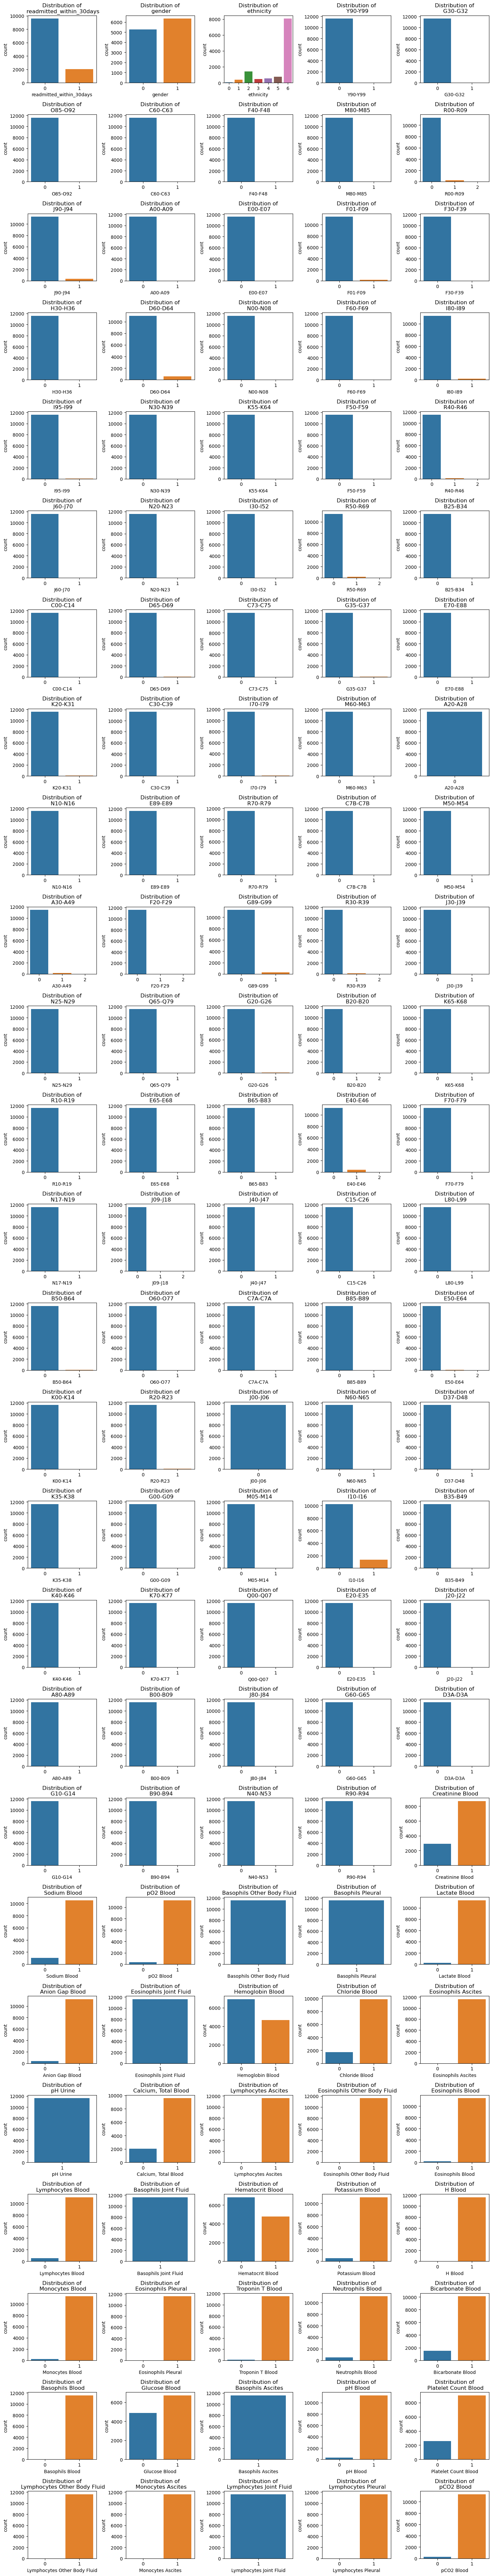

Numerical features:


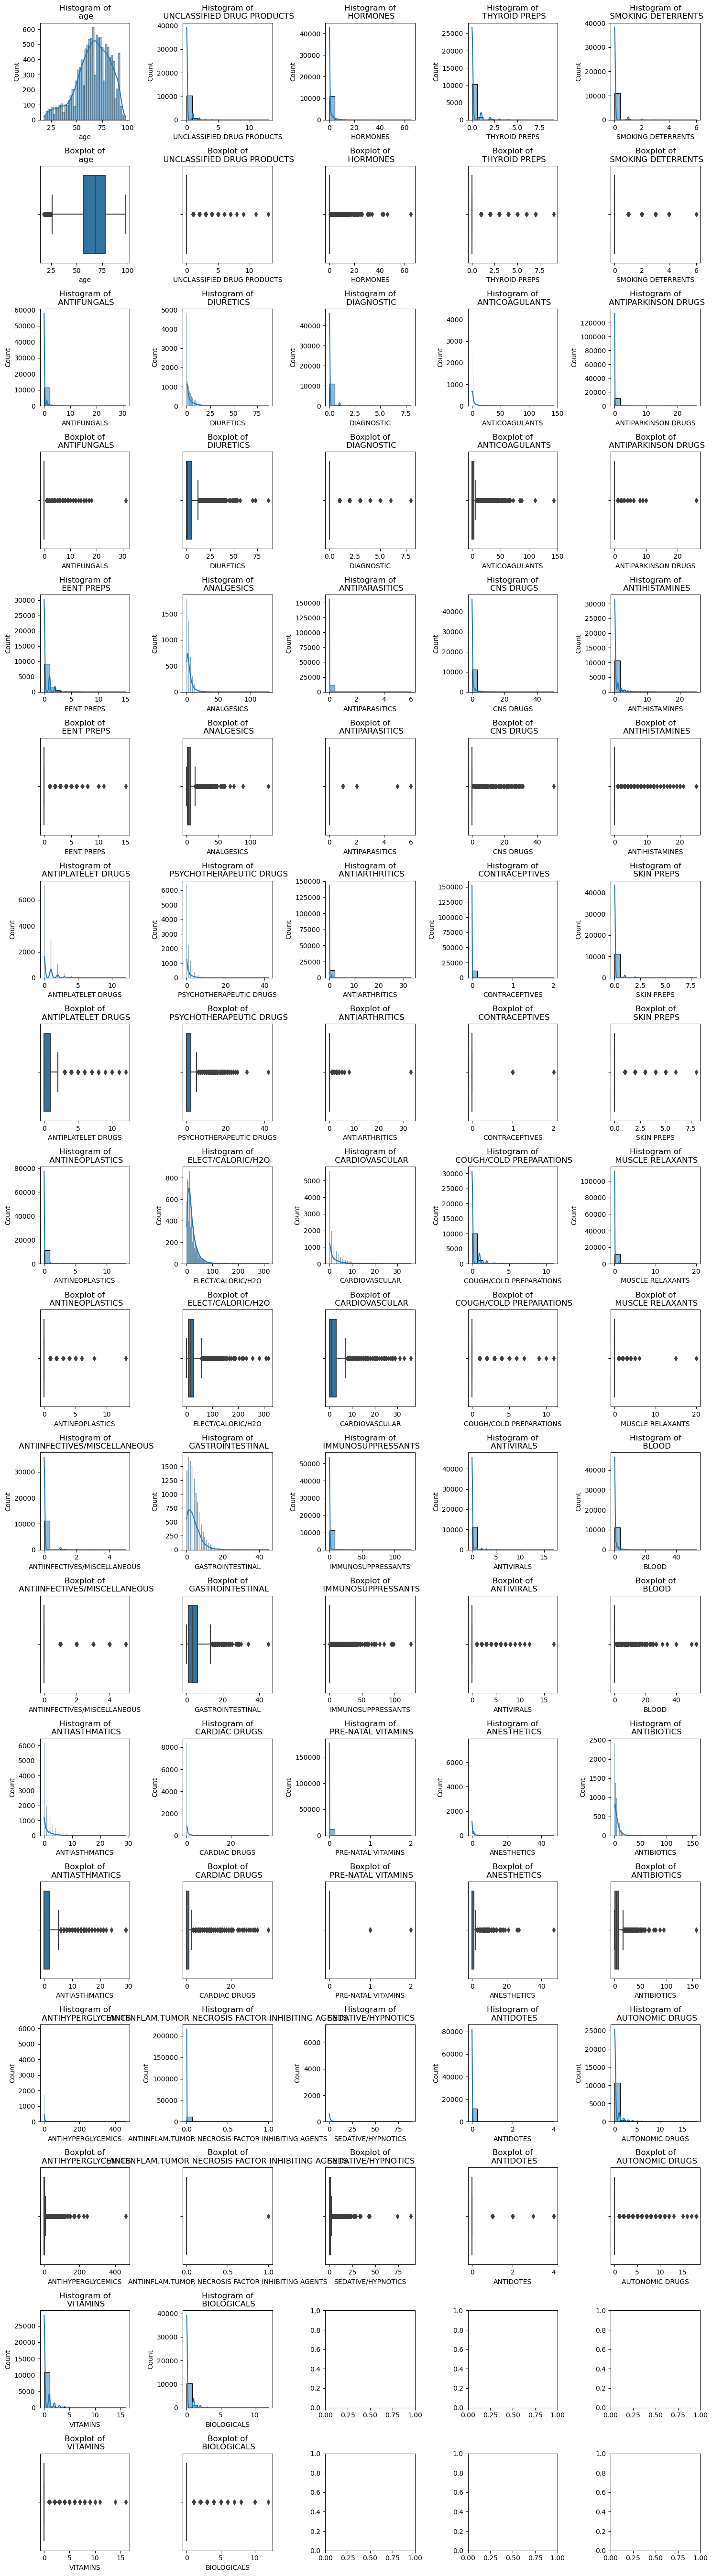

In [48]:
# plot distributions (train - latest feature value)
cat_cols_latest = [col for col in train_merged_df_latest.columns[12:] if col in cat_cols or col in icd_cols]
num_cols_latest = [col for col in train_merged_df_latest.columns[12:] if col not in cat_cols_latest]

# Plot categorical columns
print("Categorical features:")
num_rows = math.ceil(len(cat_cols_latest) / 5)
fig, axs = plt.subplots(num_rows, 5, figsize=(15, num_rows*3))
axs = axs.flatten()
for i, col in enumerate(cat_cols_latest):
    sns.countplot(x=col, data=train_merged_df_latest, ax=axs[i])
    axs[i].set_title(f'Distribution of\n {col}')
plt.tight_layout()
plt.show()

# Plot numerical columns
print("Numerical features:")
num_rows = math.ceil(len(num_cols_latest) / 5) * 2  
fig, axs = plt.subplots(num_rows, 5, figsize=(15, num_rows*3))
axs = axs.flatten()
for i, col in enumerate(num_cols_latest):
    row = (i // 5) * 2  
    sns.histplot(train_merged_df_latest[col], kde=True, ax=axs[row*5 + i%5])  
    sns.boxplot(x=train_merged_df_latest[col], ax=axs[(row+1)*5 + i%5])  
    axs[row*5 + i%5].set_title(f'Histogram of\n {col}')
    axs[(row+1)*5 + i%5].set_title(f'Boxplot of\n {col}')
plt.tight_layout()
plt.show()
# some features are constant over all observations
# no predictive power, need to be removed afterwards!

Categorical features:


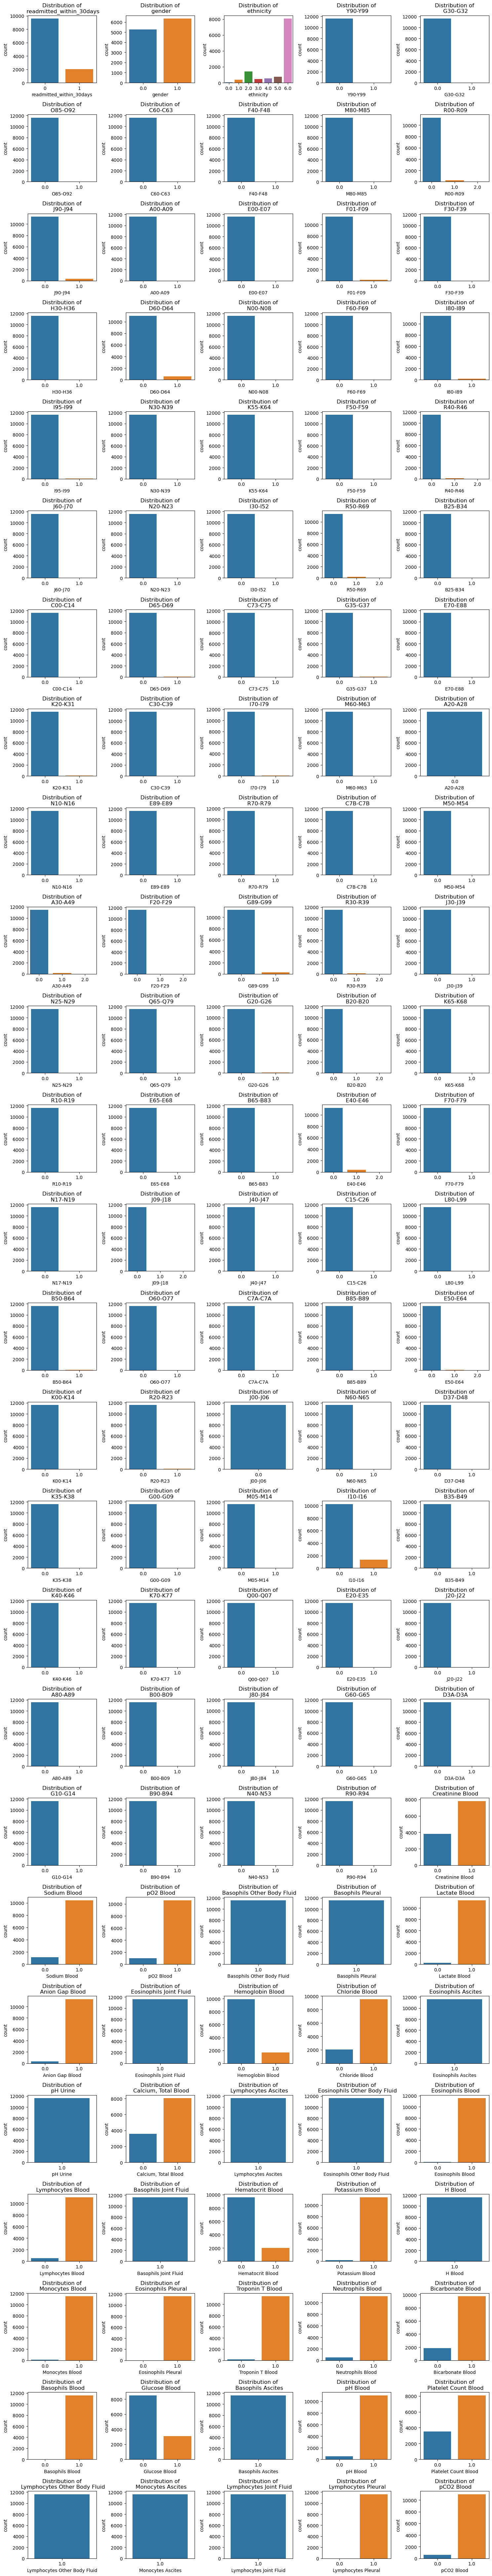

Numerical features:


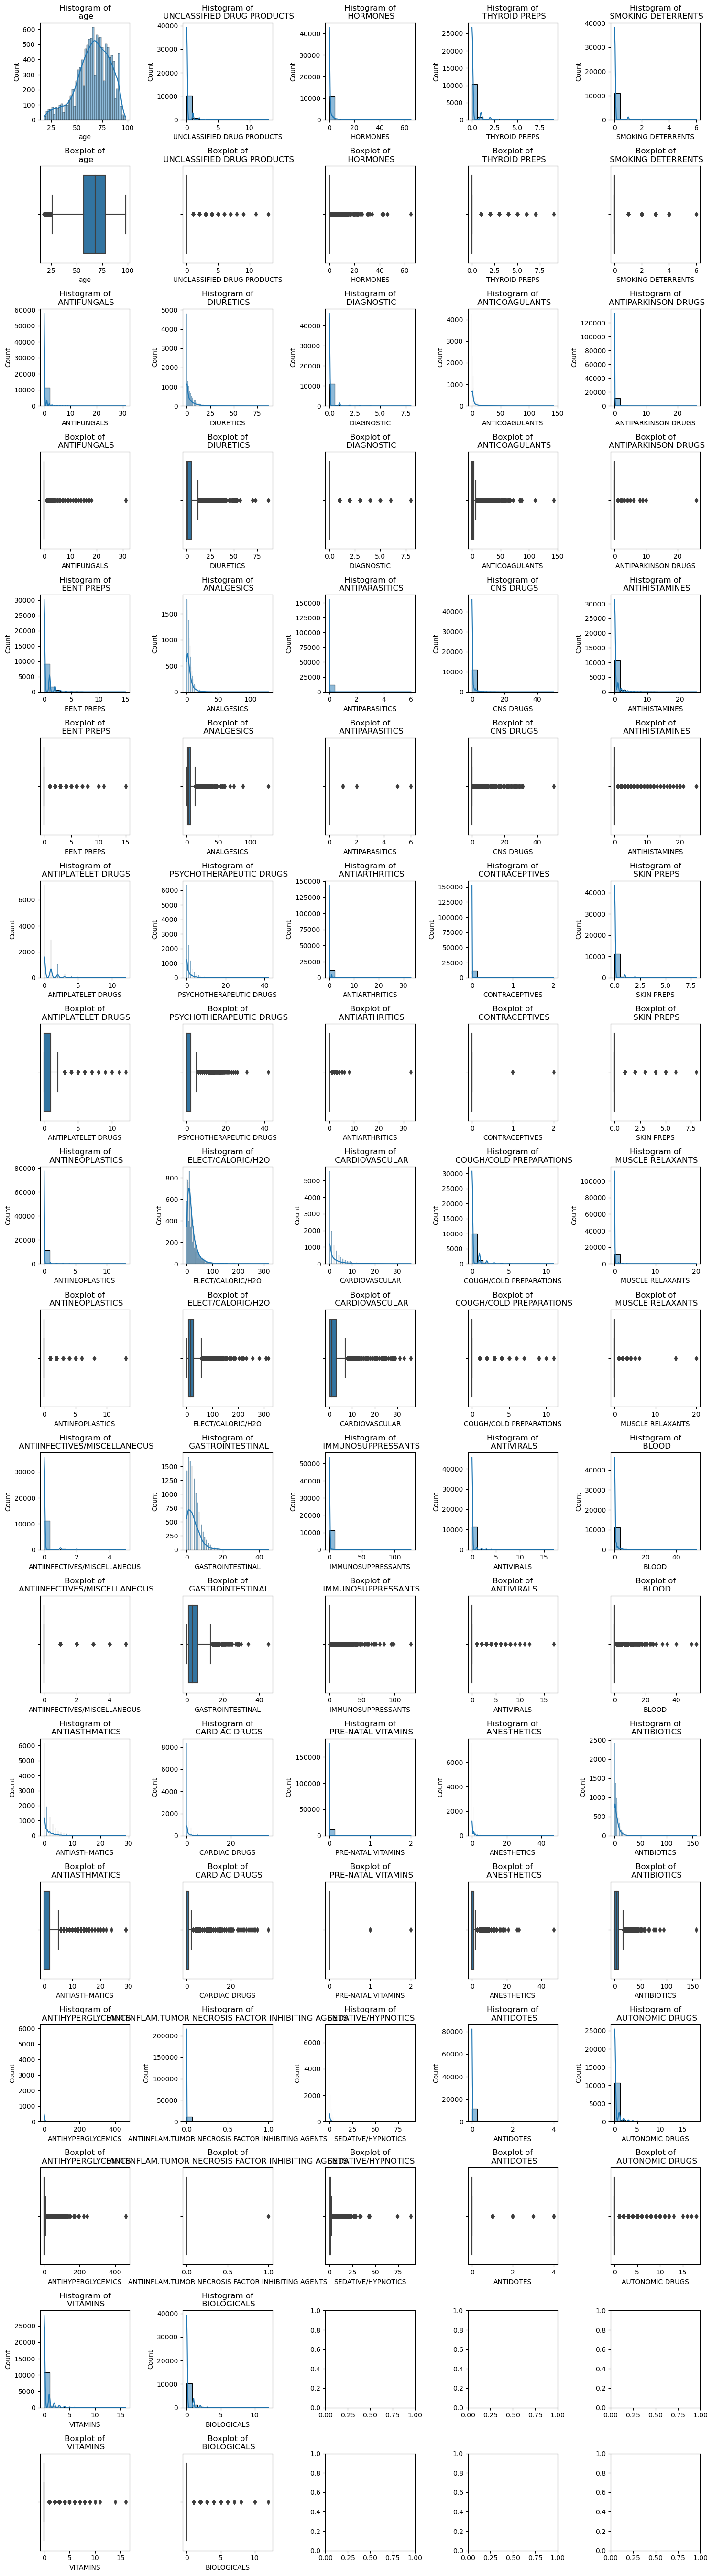

In [49]:
# plot distributions (train - median feature value)
cat_cols_median = [col for col in train_merged_df_median.columns[12:] if col in cat_cols or col in icd_cols]
num_cols_median = [col for col in train_merged_df_median.columns[12:] if col not in cat_cols_median]

# Plot categorical columns
print("Categorical features:")
num_rows = math.ceil(len(cat_cols_median) / 5)
fig, axs = plt.subplots(num_rows, 5, figsize=(15, num_rows*3))
axs = axs.flatten()
for i, col in enumerate(cat_cols_median):
    sns.countplot(x=col, data=train_merged_df_median, ax=axs[i])
    axs[i].set_title(f'Distribution of\n {col}')
plt.tight_layout()
plt.show()

# Plot numerical columns
print("Numerical features:")
num_rows = math.ceil(len(num_cols_median) / 5) * 2  
fig, axs = plt.subplots(num_rows, 5, figsize=(15, num_rows*3))
axs = axs.flatten()
for i, col in enumerate(num_cols_median):
    row = (i // 5) * 2  
    sns.histplot(train_merged_df_median[col], kde=True, ax=axs[row*5 + i%5])  
    sns.boxplot(x=train_merged_df_median[col], ax=axs[(row+1)*5 + i%5])  
    axs[row*5 + i%5].set_title(f'Histogram of\n {col}')
    axs[(row+1)*5 + i%5].set_title(f'Boxplot of\n {col}')
plt.tight_layout()
plt.show()

Categorical features:


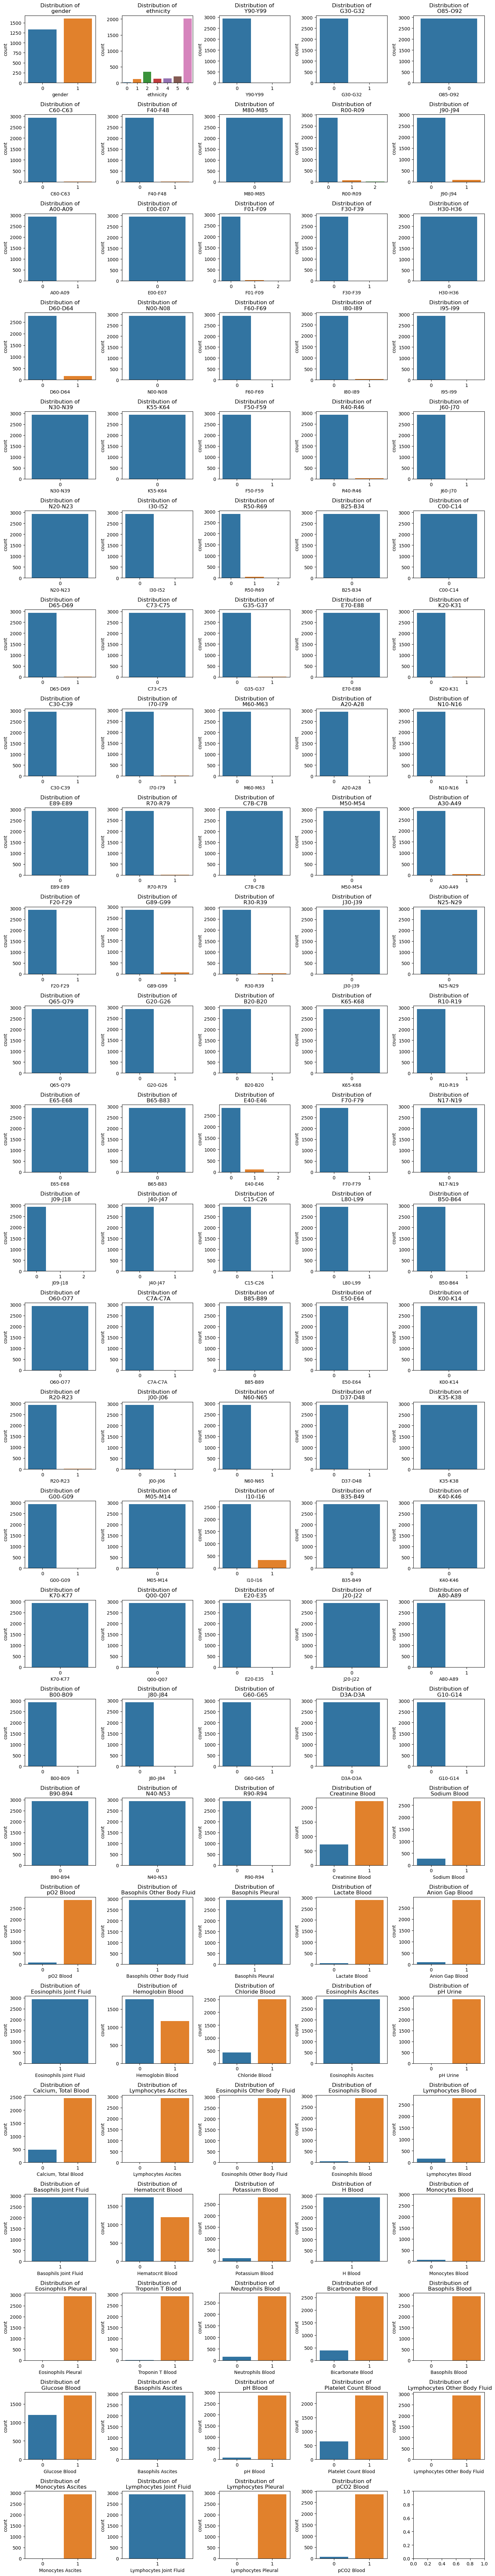

Numerical features:


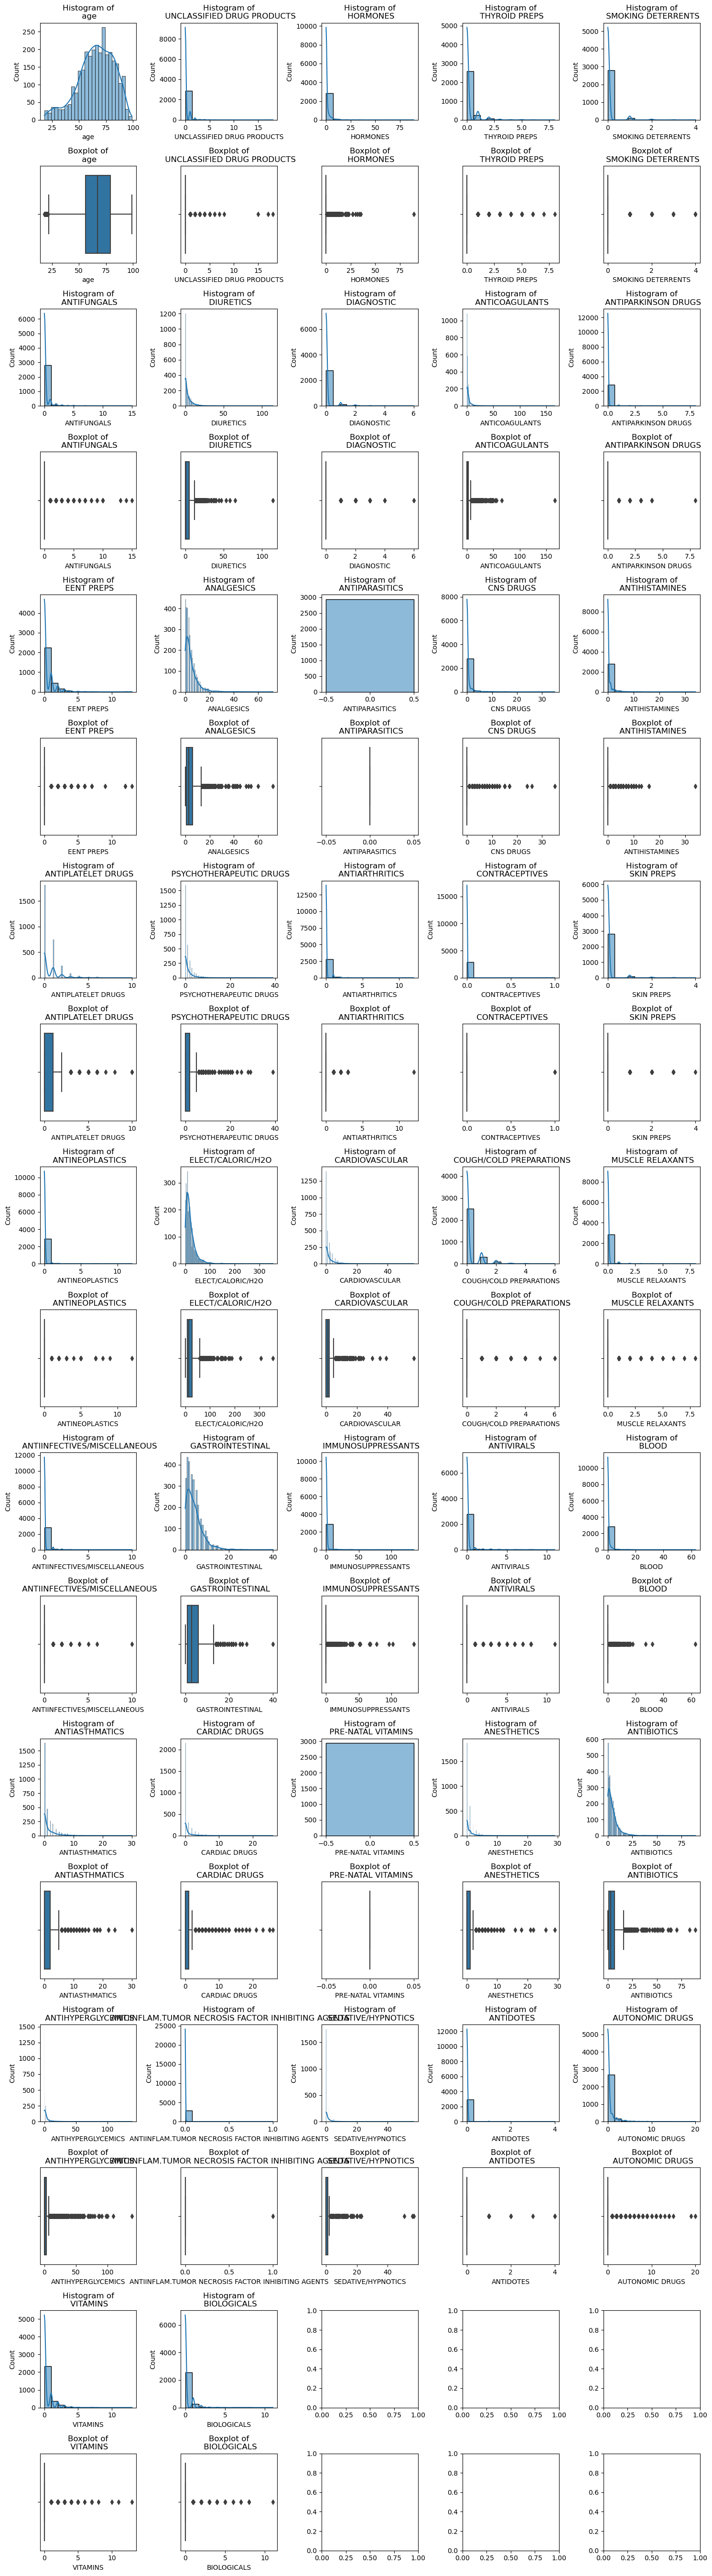

In [59]:
# plot distributions (test - latest feature value)
cat_cols.remove('readmitted_within_30days')
cat_cols_latest = [col for col in test_merged_df_latest.columns[12:] if col in cat_cols or col in icd_cols] 
num_cols_latest = [col for col in test_merged_df_latest.columns[12:] if col not in cat_cols_latest]

# Plot categorical columns
print("Categorical features:")
num_rows = math.ceil(len(cat_cols_latest) / 5)
fig, axs = plt.subplots(num_rows, 5, figsize=(15, num_rows*3))
axs = axs.flatten()
for i, col in enumerate(cat_cols_latest):
    sns.countplot(x=col, data=test_merged_df_latest, ax=axs[i])
    axs[i].set_title(f'Distribution of\n {col}')
plt.tight_layout()
plt.show()

# Plot numerical columns
print("Numerical features:")
num_rows = math.ceil(len(num_cols_latest) / 5) * 2  
fig, axs = plt.subplots(num_rows, 5, figsize=(15, num_rows*3))
axs = axs.flatten()
for i, col in enumerate(num_cols_latest):
    row = (i // 5) * 2  
    sns.histplot(test_merged_df_latest[col], kde=True, ax=axs[row*5 + i%5])  
    sns.boxplot(x=test_merged_df_latest[col], ax=axs[(row+1)*5 + i%5])  
    axs[row*5 + i%5].set_title(f'Histogram of\n {col}')
    axs[(row+1)*5 + i%5].set_title(f'Boxplot of\n {col}')
plt.tight_layout()
plt.show()

Categorical features:


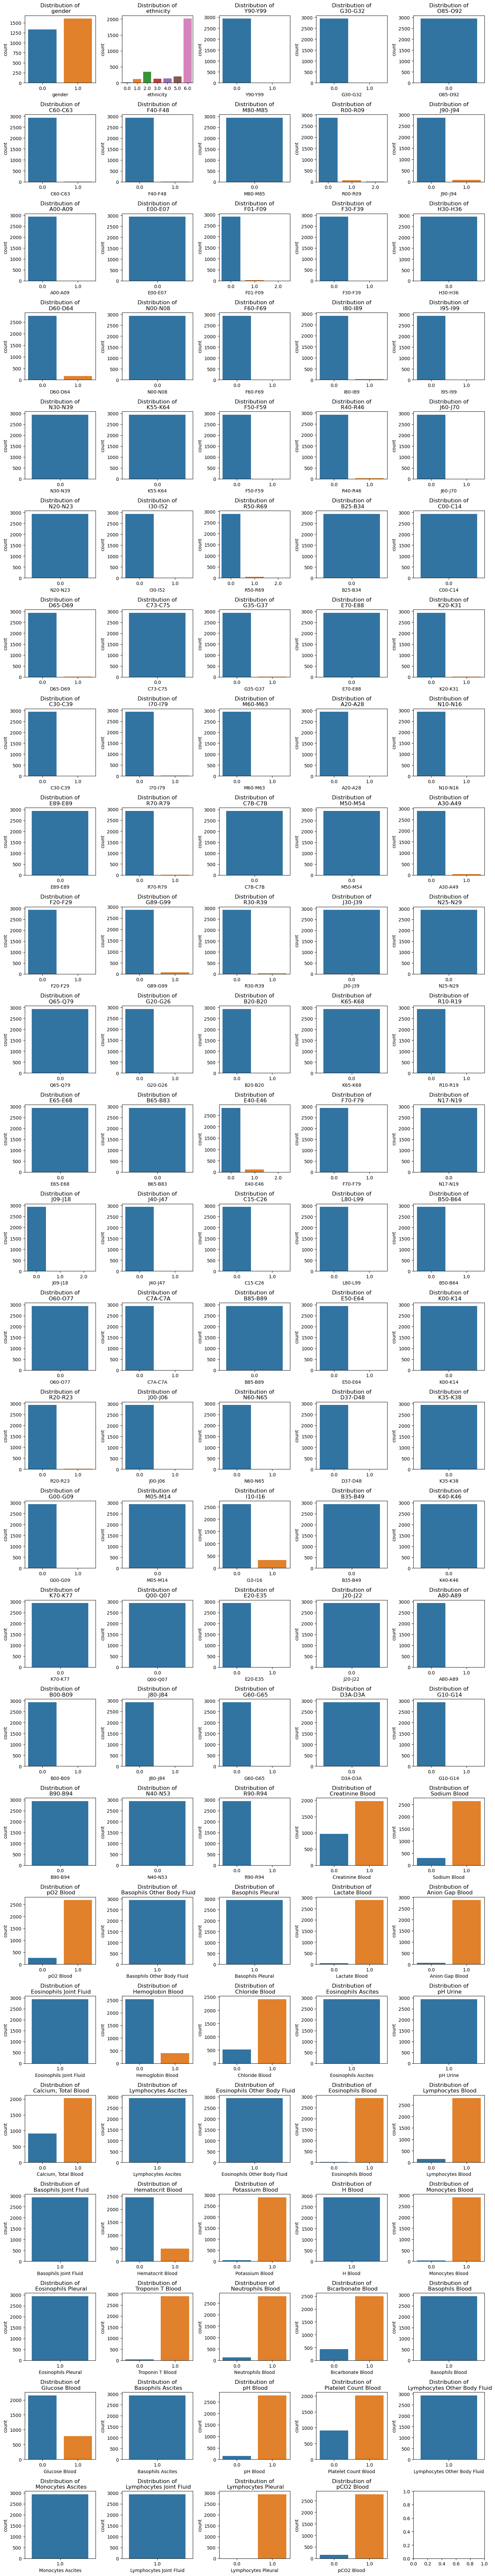

Numerical features:


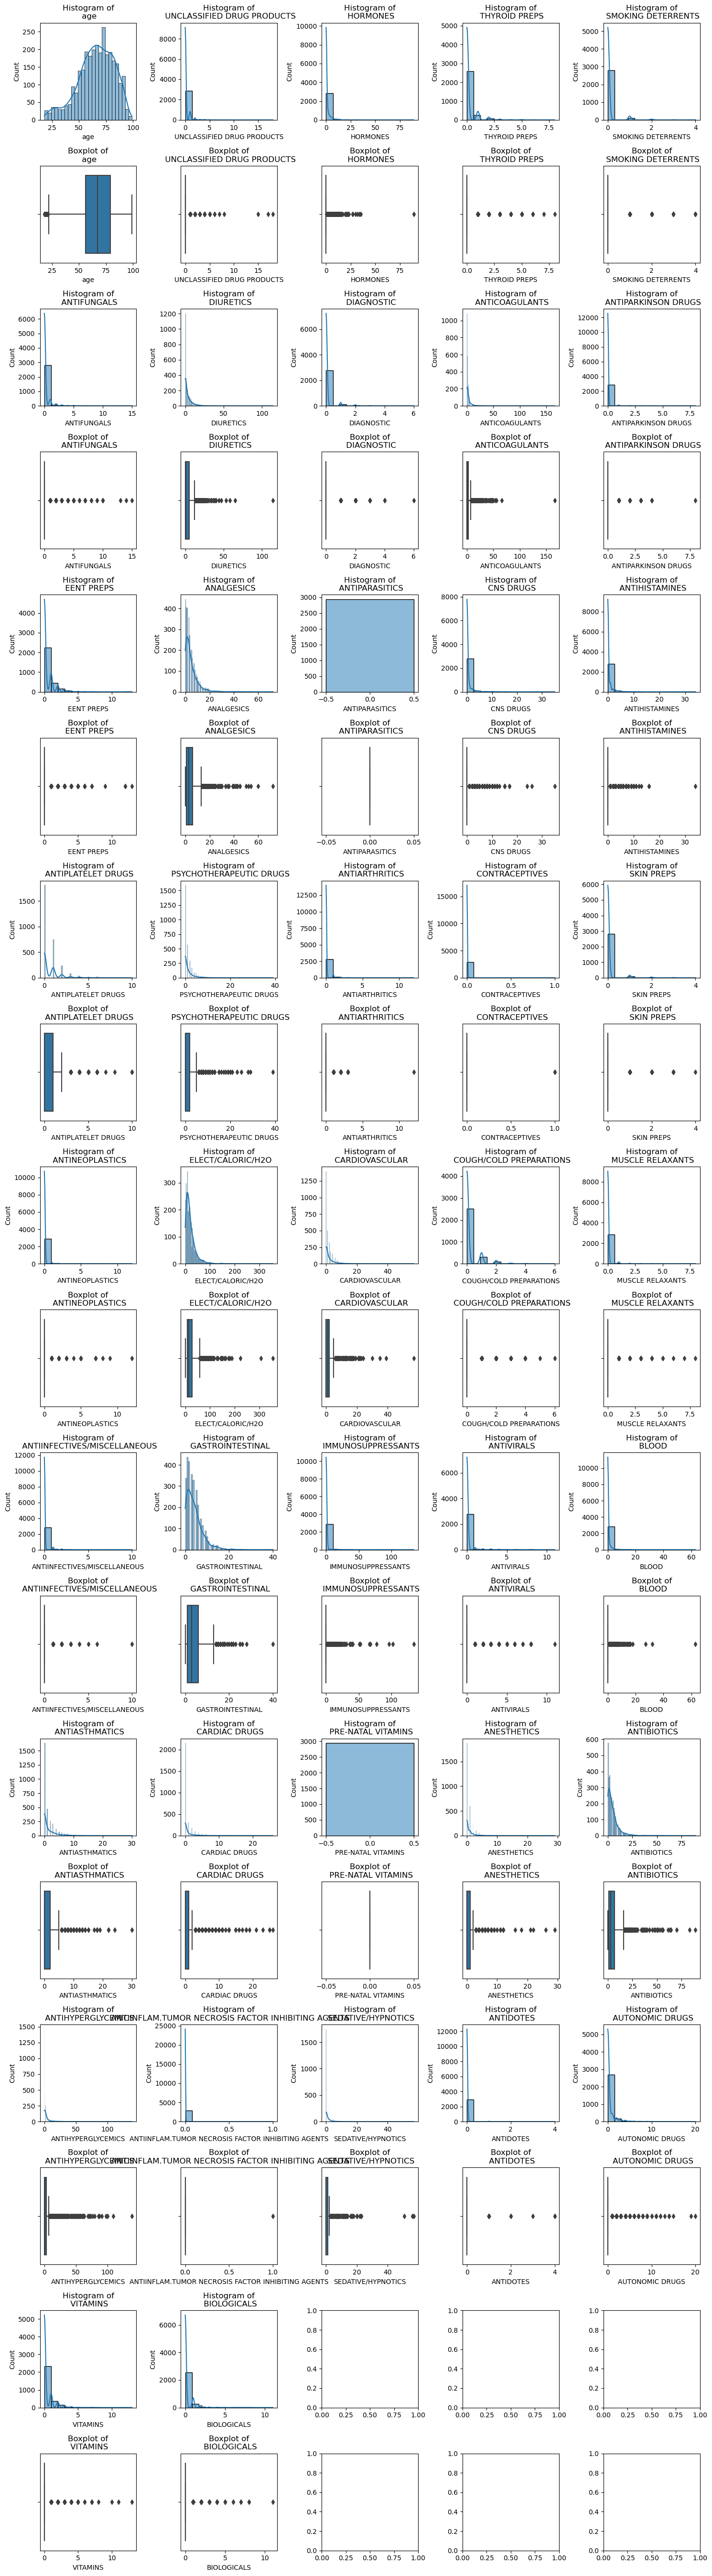

In [62]:
# plot distributions (test - median feature value)
cat_cols_median = [col for col in test_merged_df_median.columns[12:] if col in cat_cols or col in icd_cols]
num_cols_median = [col for col in test_merged_df_median.columns[12:] if col not in cat_cols_median]

# Plot categorical columns
print("Categorical features:")
num_rows = math.ceil(len(cat_cols_median) / 5)
fig, axs = plt.subplots(num_rows, 5, figsize=(15, num_rows*3))
axs = axs.flatten()
for i, col in enumerate(cat_cols_median):
    sns.countplot(x=col, data=test_merged_df_median, ax=axs[i])
    axs[i].set_title(f'Distribution of\n {col}')
plt.tight_layout()
plt.show()

# Plot numerical columns
print("Numerical features:")
num_rows = math.ceil(len(num_cols_median) / 5) * 2  
fig, axs = plt.subplots(num_rows, 5, figsize=(15, num_rows*3))
axs = axs.flatten()
for i, col in enumerate(num_cols_median):
    row = (i // 5) * 2  
    sns.histplot(test_merged_df_median[col], kde=True, ax=axs[row*5 + i%5])  
    sns.boxplot(x=test_merged_df_median[col], ax=axs[(row+1)*5 + i%5])  
    axs[row*5 + i%5].set_title(f'Histogram of\n {col}')
    axs[(row+1)*5 + i%5].set_title(f'Boxplot of\n {col}')
plt.tight_layout()
plt.show()

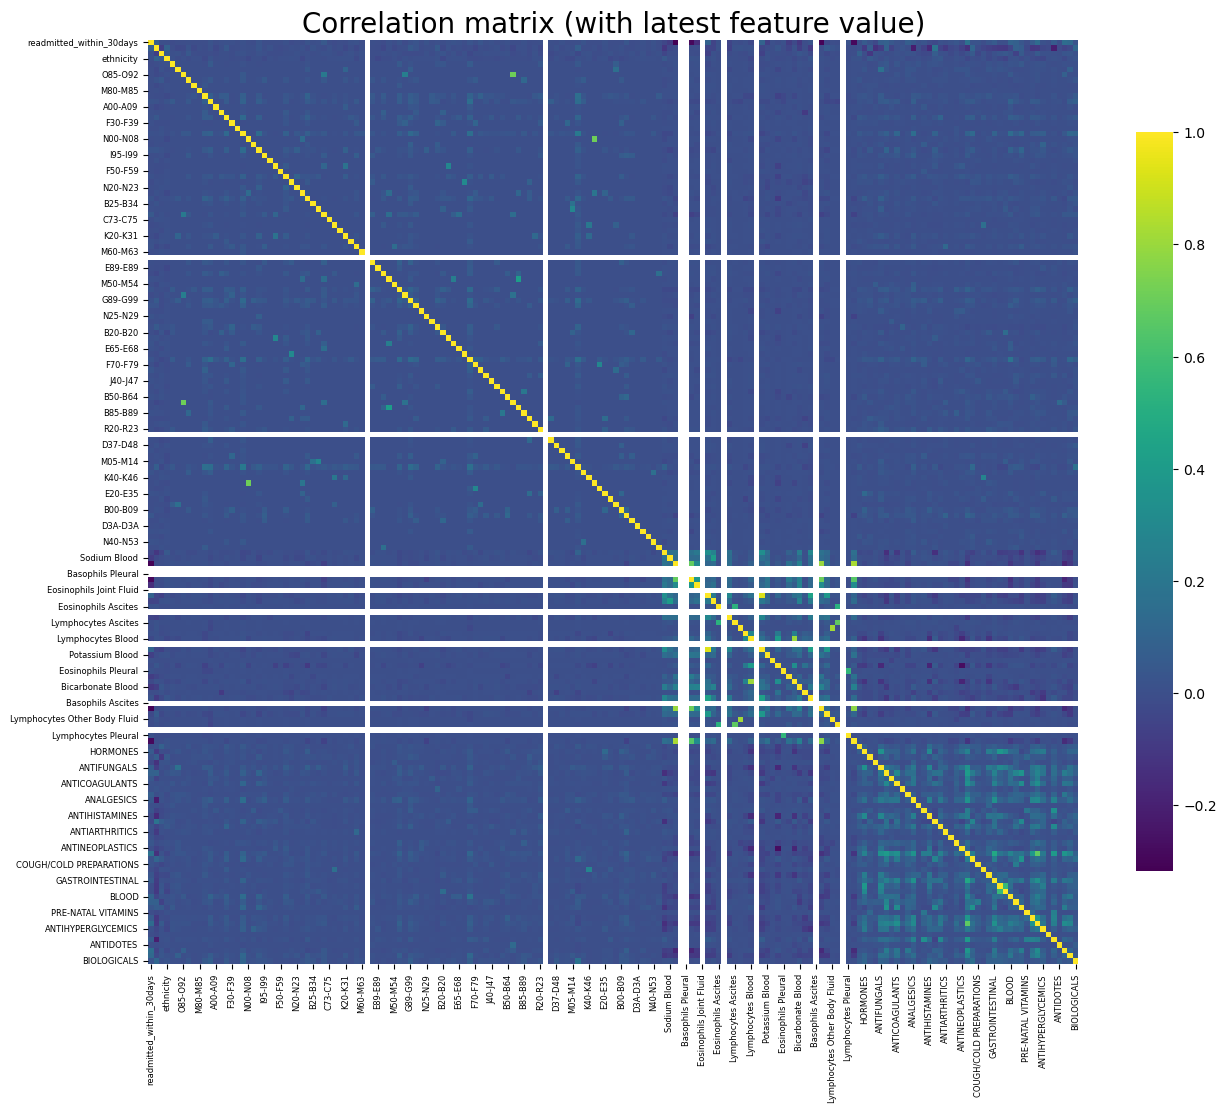

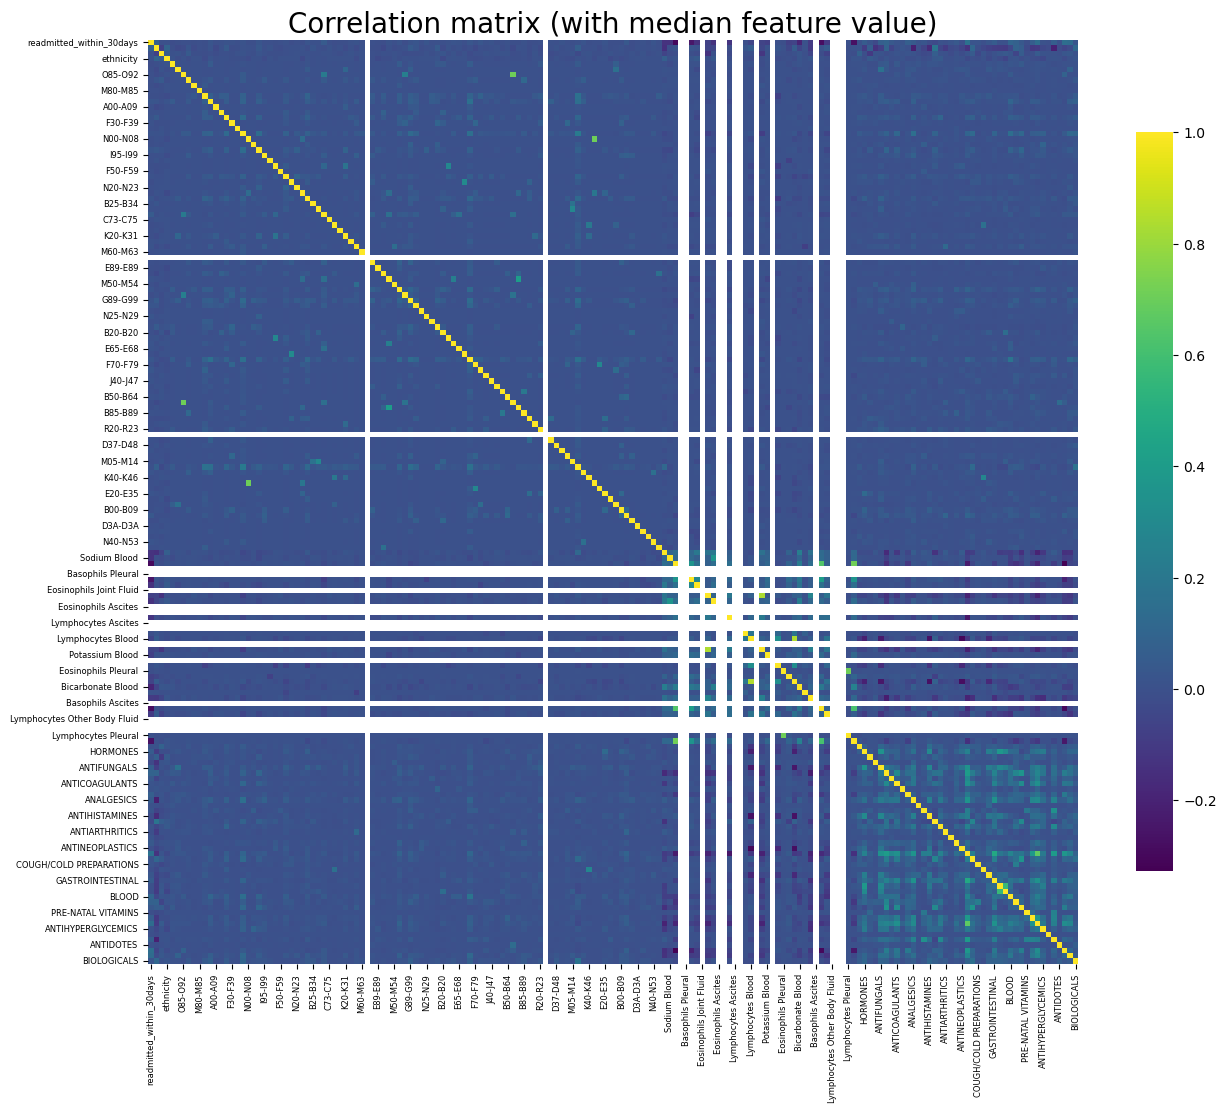

In [34]:
# correlation test 
# latest feature value
feat_resp_cols_latest = train_merged_df_latest.columns[12:].to_list()
corr_mat_latest = train_merged_df_latest[feat_resp_cols_latest].corr()

plt.figure(figsize=(15, 12))
sns.heatmap(corr_mat_latest, annot=False, fmt=".2f", cmap='viridis',  cbar_kws={"shrink": .8})
plt.title("Correlation matrix (with latest feature value)", fontsize=20)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.show()

# median feature value
feat_resp_cols_median = train_merged_df_median.columns[12:].to_list()
corr_mat_median = train_merged_df_median[feat_resp_cols_median].corr()

plt.figure(figsize=(15, 12))
sns.heatmap(corr_mat_median, annot=False, fmt=".2f", cmap='viridis',  cbar_kws={"shrink": .8})
plt.title("Correlation matrix (with median feature value)", fontsize=20)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.show()
# some features are constant over all observations
# no predictive power, need to be removed!

In [35]:
# drop features with constant values in the training set
feat_cols_latest = train_merged_df_latest.columns[13:].to_list()
feat_cols_median = train_merged_df_median.columns[13:].to_list()
const_cols_latest = [col for col in feat_cols_latest if train_merged_df_latest[col].nunique() <= 1]
const_cols_median = [col for col in feat_cols_median if train_merged_df_median[col].nunique() <= 1]
print(const_cols_latest)
print(const_cols_median)

train_merged_df_latest = train_merged_df_latest.drop(columns=const_cols_latest, axis=1)
train_merged_df_median = train_merged_df_median.drop(columns=const_cols_median, axis=1)
test_merged_df_latest = test_merged_df_latest.drop(columns=const_cols_latest, axis=1)
test_merged_df_median = test_merged_df_median.drop(columns=const_cols_median, axis=1)

print(train_merged_df_latest.shape)
print(train_merged_df_median.shape)

['A20-A28', 'J00-J06', 'Basophils Other Body Fluid', 'Basophils Pleural', 'Eosinophils Joint Fluid', 'pH Urine', 'Basophils Joint Fluid', 'Basophils Ascites', 'Lymphocytes Joint Fluid']
['A20-A28', 'J00-J06', 'Basophils Other Body Fluid', 'Basophils Pleural', 'Eosinophils Joint Fluid', 'Eosinophils Ascites', 'pH Urine', 'Lymphocytes Ascites', 'Eosinophils Other Body Fluid', 'Basophils Joint Fluid', 'H Blood', 'Basophils Ascites', 'Lymphocytes Other Body Fluid', 'Monocytes Ascites', 'Lymphocytes Joint Fluid']
(11596, 175)
(11596, 169)


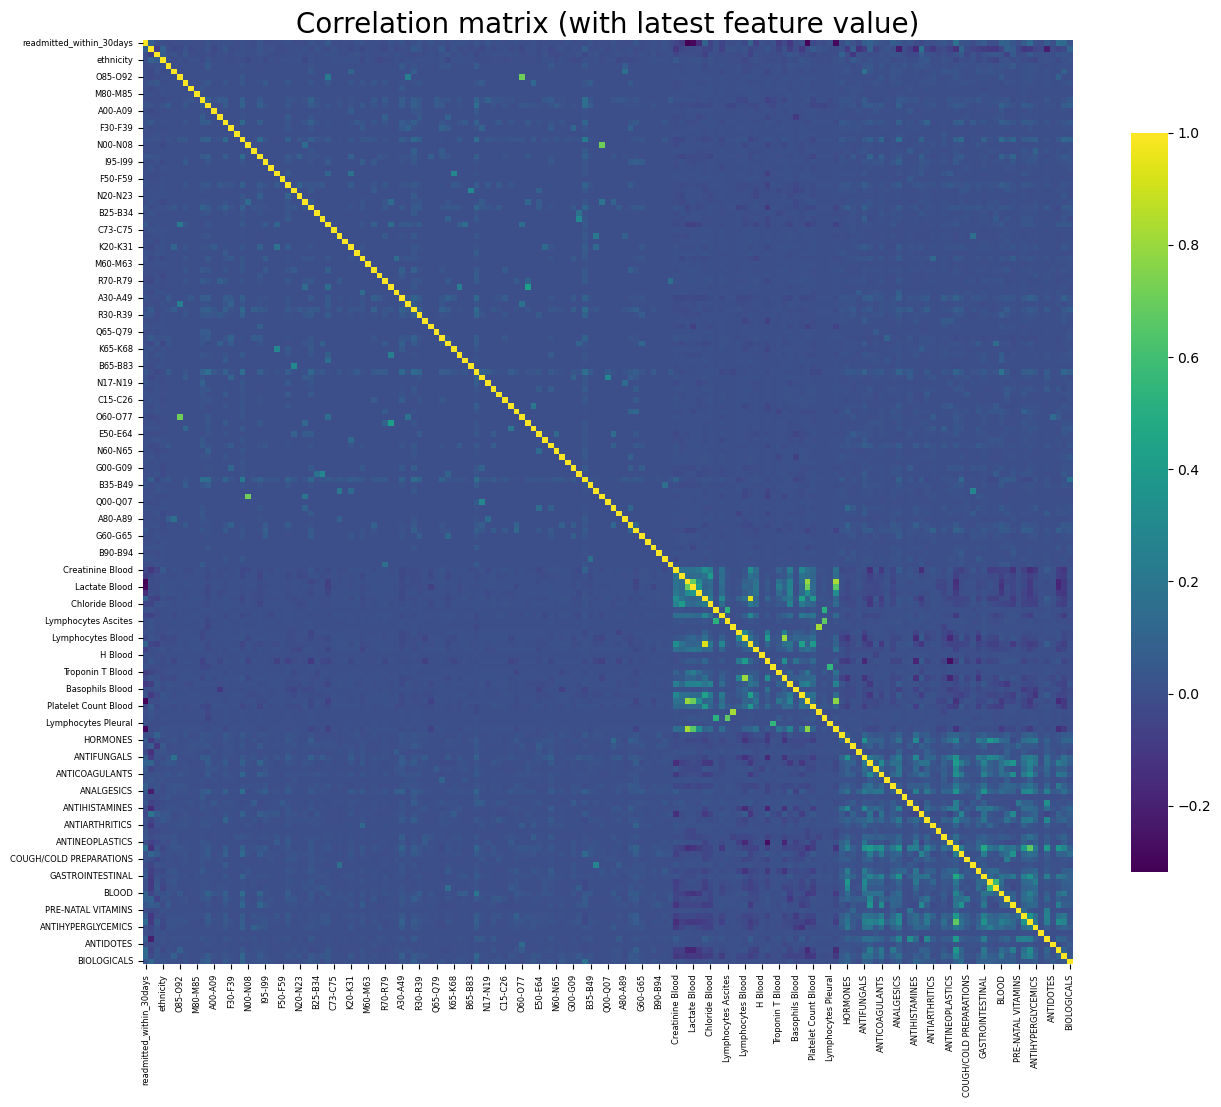

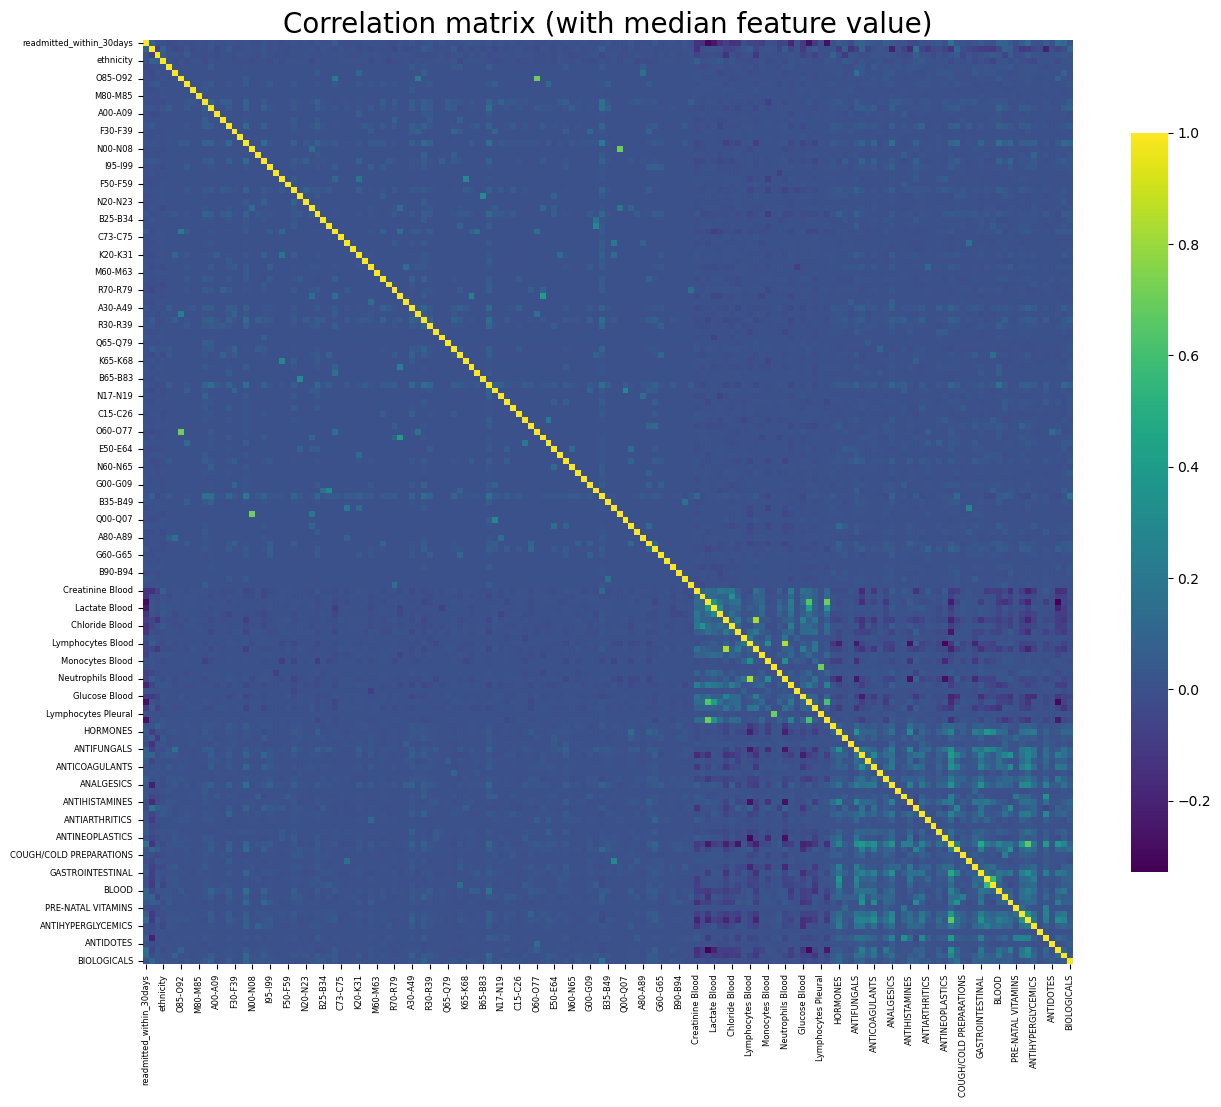

In [36]:
# correlation test 
# after dropping constant features
# latest feature value
feat_resp_cols_latest = train_merged_df_latest.columns[12:].to_list()
corr_mat_latest = train_merged_df_latest[feat_resp_cols_latest].corr()

plt.figure(figsize=(15, 12))
sns.heatmap(corr_mat_latest, annot=False, fmt=".2f", cmap='viridis',  cbar_kws={"shrink": .8})
plt.title("Correlation matrix (with latest feature value)", fontsize=20)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.show()

# median feature value
feat_resp_cols_median = train_merged_df_median.columns[12:].to_list()
corr_mat_median = train_merged_df_median[feat_resp_cols_median].corr()

plt.figure(figsize=(15, 12))
sns.heatmap(corr_mat_median, annot=False, fmt=".2f", cmap='viridis',  cbar_kws={"shrink": .8})
plt.title("Correlation matrix (with median feature value)", fontsize=20)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.show()
# address for multicolinarity?
# remove features with correlation < 0.01?